<a href="https://colab.research.google.com/github/jean-on-hub/Image-Captioning/blob/model_building/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Necessary libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

###Import the data

Coco dataset import

Annotations

In [3]:

annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


252887040/252872794 [==============================] - 16s 0us/step


In [4]:
from pathlib import Path
annotation_file =Path('/content/annotations/captions_train2014.json')

In [5]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

###Images

In [6]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 810s 0us/step


In [7]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + '/COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

List of images paths

In [8]:
image_paths = list(image_path_to_caption.keys())

captions and vector list

In [9]:
train_captions = []
img_name_vector = []

for image_path in image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

Data Example

<start> A stop sign that has been vandalized is pictured in front of a parked car. <end>


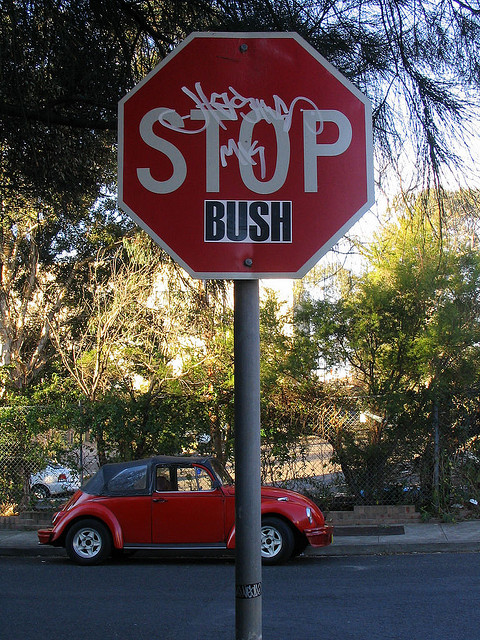

In [10]:
print(train_captions[13])

Image.open(img_name_vector[13])

In [11]:
img_name_vector[0].split('/')[-1]

'COCO_train2014_000000318556.jpg'

### Create train and evaluation dataset

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/',class_names =None,labels= None,
  
  seed=123,
  
  batch_size=32 )

Found 84012 files belonging to 1 classes.


In [13]:
train_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

###Model to extract image features

In [13]:
from tensorflow import keras
from keras import layers

###Model

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [129]:
model = keras.Sequential([
                          layers.Rescaling(1./255,input_shape=(256,256,3)),
                          layers.Conv2D(8,(3,3),padding='same',activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(128,(3,3), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(256, (5,5), padding='same', activation='relu'),
  layers.Conv2D(256, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(1024,(5,5), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(2048,(3,3), padding = 'same', activation = 'relu'),
  
 
  
  
])

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
a = model.layers[1]

a.get_weights()

In [17]:
model = tf.keras.models.clone_model(model)

In [ ]:
model.summary()

In [212]:
a =model.get_weights()
model.set_weights(a +1)

TypeError: ignored

In [31]:
!pip install keras

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True)

In [24]:
!pip install tqdm
from tqdm import tqdm

### Extract features

Pre-process images

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [20]:
image_dataset = image_dataset.map(load_image,
  num_parallel_calls=tf.data.AUTOTUNE).batch(64)

In [25]:
for img, path in tqdm(image_dataset):
  batch_features = model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1294/1294 [08:35<00:00,  2.51it/s]


In [26]:
batch_features.shape

TensorShape([31, 64, 2048])

### CAPTIONS

In [27]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

overide default standardization to preserve <> in captions

In [28]:
len(caption_dataset)

414113

In [29]:
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

In [30]:
# Max word count for a caption.
max_length = 50

vocabulary_size = None
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [31]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [32]:
cap_vector

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [33]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Split data into train and test model

In [34]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in tqdm(zip(img_name_vector, cap_vector)):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in tqdm(img_name_train_keys):
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in tqdm(img_name_val_keys):
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

414113it [02:03, 3359.52it/s]
100%|██████████| 16557/16557 [00:00<00:00, 567463.85it/s]


In [72]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(331286, 331286, 82827, 82827)

create Tf dataset

In [35]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [36]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Main Model

The model architecture is inspired by the Show, Attend and Tell paper.

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [39]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [40]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [41]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [42]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoint

In [43]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Training

In [45]:
loss_plot = []

In [46]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [47]:
EPOCHS = 20

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            # print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  5%|▌         | 1/20 [28:46<9:06:51, 1726.90s/it]

Epoch 1 Loss 0.917100
Time taken for 1 epoch 1726.90 sec



 10%|█         | 2/20 [55:58<8:21:20, 1671.13s/it]

Epoch 2 Loss 0.797337
Time taken for 1 epoch 1632.07 sec



 15%|█▌        | 3/20 [1:23:10<7:48:23, 1653.16s/it]

Epoch 3 Loss 0.758249
Time taken for 1 epoch 1631.78 sec



 20%|██        | 4/20 [1:50:22<7:18:33, 1644.60s/it]

Epoch 4 Loss 0.733646
Time taken for 1 epoch 1631.44 sec



 25%|██▌       | 5/20 [2:17:33<6:49:58, 1639.88s/it]

Epoch 5 Loss 0.713941
Time taken for 1 epoch 1631.51 sec



 30%|███       | 6/20 [2:44:46<6:22:02, 1637.30s/it]

Epoch 6 Loss 0.698632
Time taken for 1 epoch 1632.27 sec



 35%|███▌      | 7/20 [3:11:57<5:54:20, 1635.40s/it]

Epoch 7 Loss 0.686507
Time taken for 1 epoch 1631.48 sec



 40%|████      | 8/20 [3:39:08<5:26:49, 1634.14s/it]

Epoch 8 Loss 0.676246
Time taken for 1 epoch 1631.41 sec



 45%|████▌     | 9/20 [4:06:20<4:59:27, 1633.37s/it]

Epoch 9 Loss 0.667229
Time taken for 1 epoch 1631.68 sec



 50%|█████     | 10/20 [4:33:32<4:32:08, 1632.87s/it]

Epoch 10 Loss 0.659143
Time taken for 1 epoch 1631.72 sec



 55%|█████▌    | 11/20 [5:00:45<4:04:55, 1632.87s/it]

Epoch 11 Loss 0.651748
Time taken for 1 epoch 1632.83 sec



 60%|██████    | 12/20 [5:27:57<3:37:41, 1632.68s/it]

Epoch 12 Loss 0.644972
Time taken for 1 epoch 1632.25 sec



 65%|██████▌   | 13/20 [5:55:09<3:10:27, 1632.54s/it]

Epoch 13 Loss 0.638922
Time taken for 1 epoch 1632.19 sec



 70%|███████   | 14/20 [6:22:22<2:43:14, 1632.48s/it]

Epoch 14 Loss 0.633378
Time taken for 1 epoch 1632.33 sec



 75%|███████▌  | 15/20 [6:49:34<2:16:02, 1632.51s/it]

Epoch 15 Loss 0.628191
Time taken for 1 epoch 1632.55 sec



 80%|████████  | 16/20 [7:16:47<1:48:50, 1632.65s/it]

Epoch 16 Loss 0.623500
Time taken for 1 epoch 1632.96 sec



 85%|████████▌ | 17/20 [7:44:00<1:21:38, 1632.68s/it]

Epoch 17 Loss 0.619141
Time taken for 1 epoch 1632.72 sec



 90%|█████████ | 18/20 [8:11:12<54:25, 1632.65s/it]  

Epoch 18 Loss 0.615055
Time taken for 1 epoch 1632.56 sec



 95%|█████████▌| 19/20 [8:38:25<27:12, 1632.64s/it]

Epoch 19 Loss 0.611121
Time taken for 1 epoch 1632.61 sec



100%|██████████| 20/20 [9:05:39<00:00, 1637.00s/it]

Epoch 20 Loss 0.607557
Time taken for 1 epoch 1634.32 sec



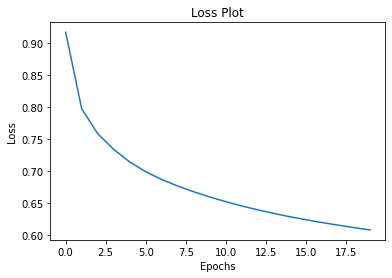

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Evaluation

In [49]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [50]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(30, 30))

  len_result = len(result)
  for i in range(len_result):
      temp_att = np.resize(attention_plot[i], (8, 8))
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(grid_size, grid_size, i+1)
      ax.set_title(result[i])
      img = ax.imshow(temp_image)
      ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

Real Caption: <start> pizza is in a box and has been cut into eight slices. <end>
Prediction Caption: a brown and white, checked, linen surface with a small red theme of a thimble. <end>


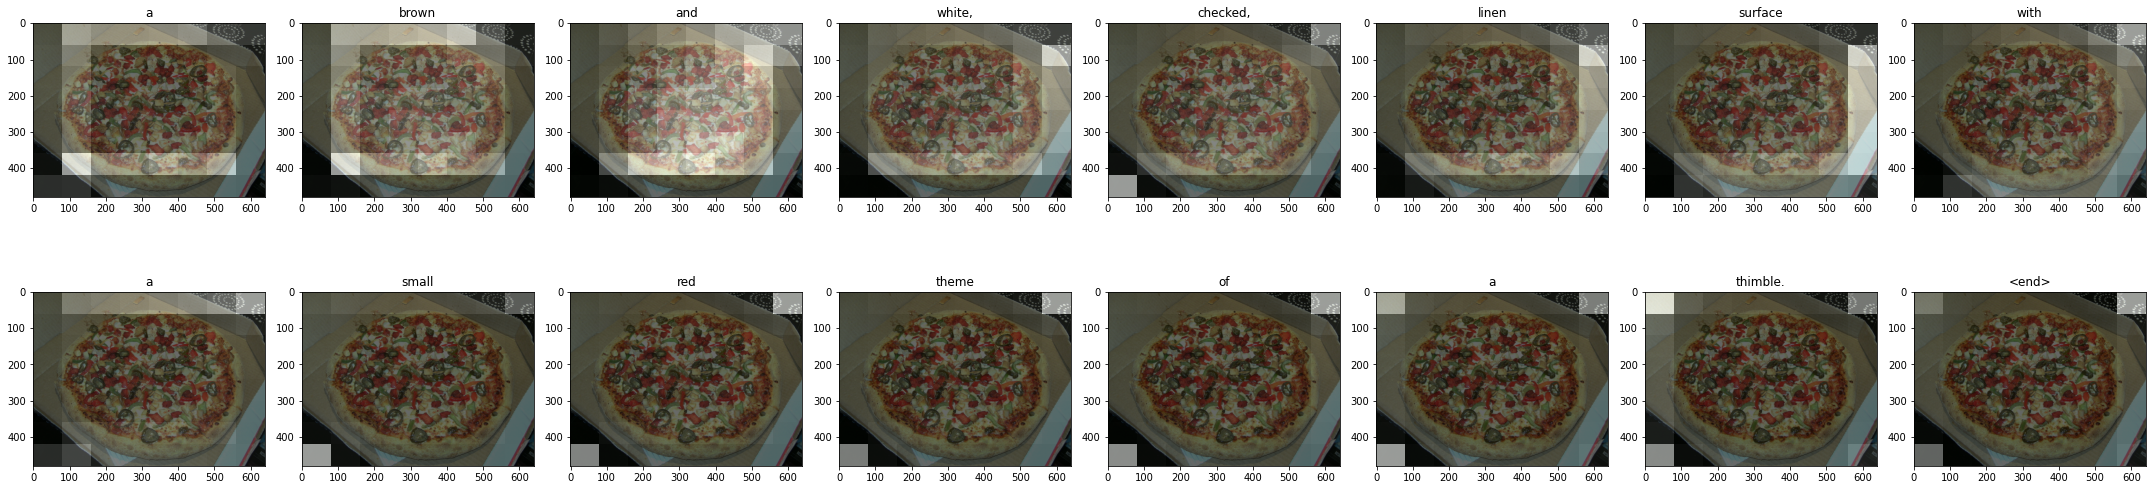

In [51]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

try

147456/132572 [=================================] - 0s 1us/step
Prediction Caption: a close up of keyboard sitting on a counter. <end>


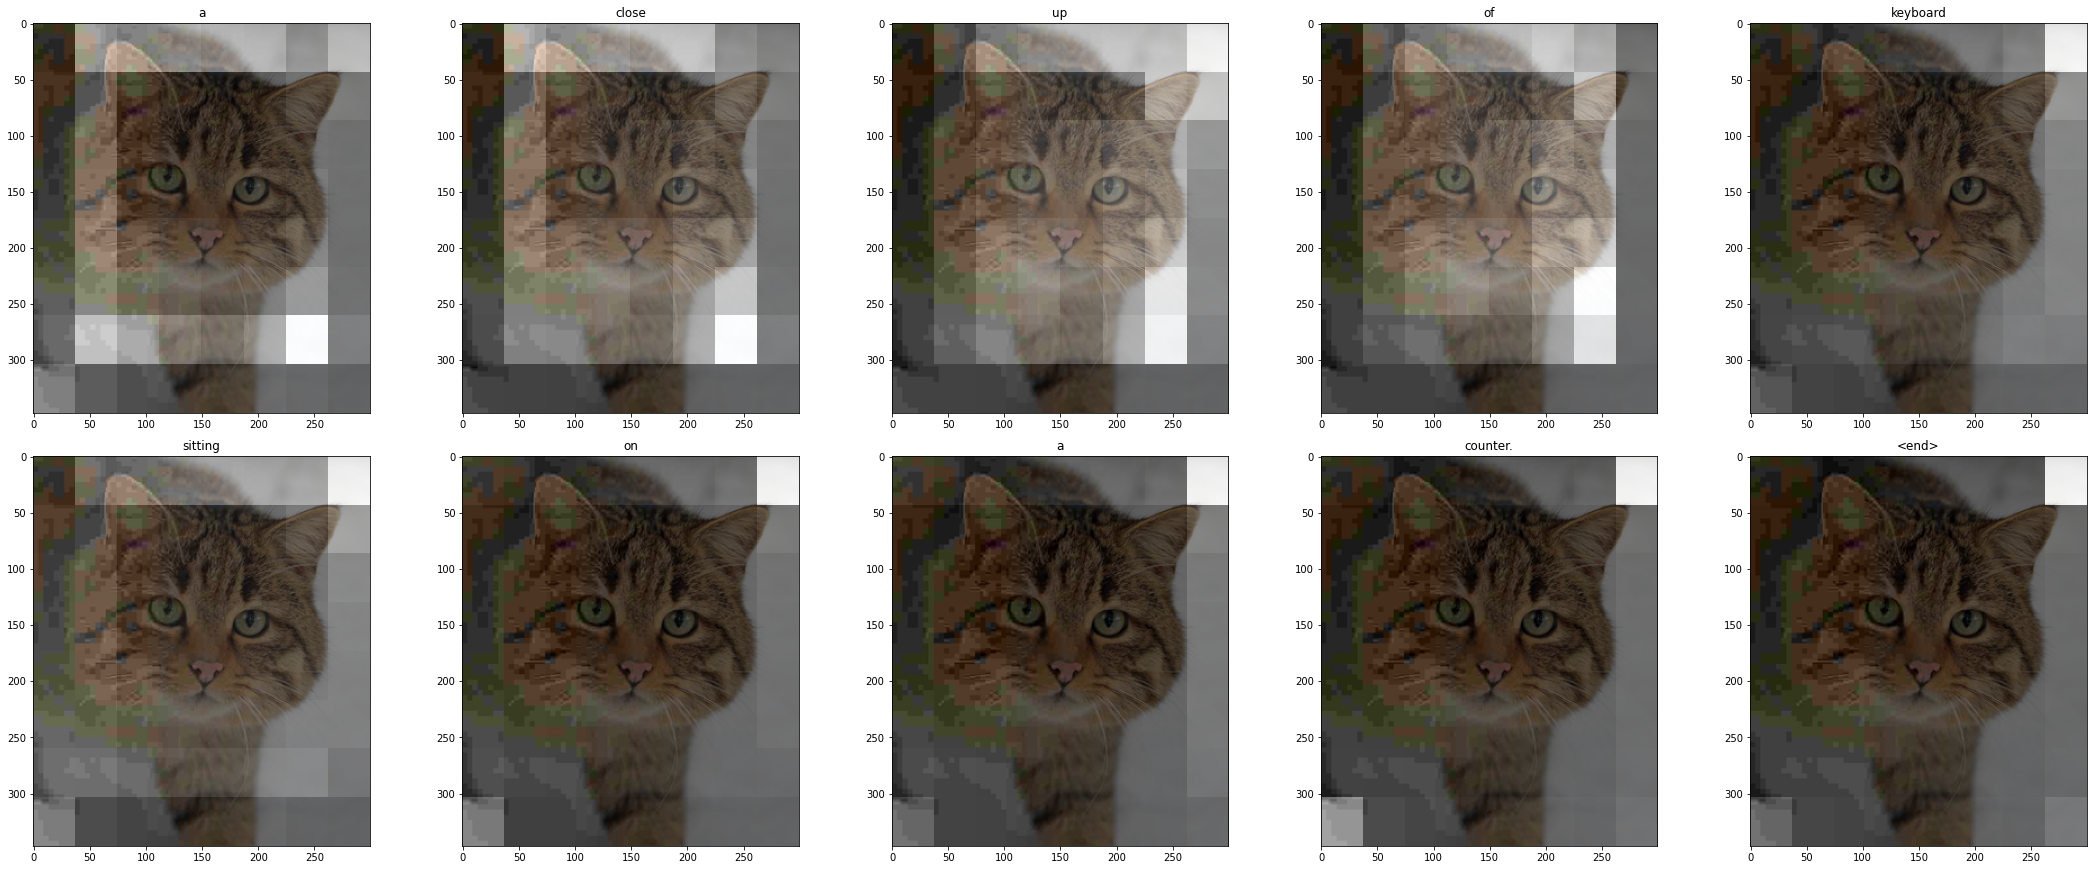

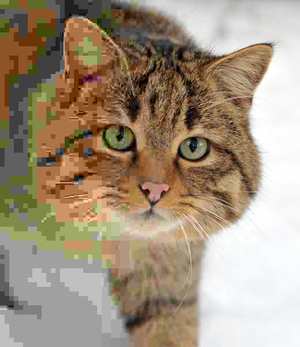

In [57]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Felis_silvestris_silvestris_small_gradual_decrease_of_quality.png/300px-Felis_silvestris_silvestris_small_gradual_decrease_of_quality.png'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

###Save model

In [97]:
encoder.save('/content/models/')

INFO:tensorflow:Assets written to: /content/models/assets


In [98]:
decoder.save('/content/models/decoder')

INFO:tensorflow:Assets written to: /content/models/decoder/assets


INFO:tensorflow:Assets written to: /content/models/decoder/assets
